# Scrape GPS data

This notebook scrapes data from [NOAA's site](https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns41/) for GPS satellite ns41, which Gruet et al. 2018 used in their analysis.

## Download ascii files

The scraping process was led by [this tutorial](https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460).

In [8]:
import requests
import urllib.request
import datetime as dt
from bs4 import BeautifulSoup

import os

import pandas as pd
import tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
url = "https://www.ngdc.noaa.gov/stp/space-weather/satellite-data/satellite-systems/gps/data/ns41/"
response = requests.get(url)

In [3]:
soup = BeautifulSoup(response.text, "html.parser")

In [4]:
# get data filenames
atags = soup.find_all('a')[6:-7]
filenames = []
for filename in atags:
    filenames.append(filename["href"])

# create download urls
urls = []
for filename in filenames:
    urls.append(url+filename)

Having extracted the urls, we can now download all of the data files. **Be careful** running the following code block as the downloading takes quite some time.

In [35]:
# download files
for i, file in enumerate(filenames):
    urllib.request.urlretrieve(urls[i], "GPS_data/" + file)

## Parse, extract magnetic field data, export to hdf5

After downloading the files, let's process them to extract the magnetic field data. Since the data are averaged in 4 minute intervals, we should bin and average them in hourly intervals. Then let's export into an hdf5 file.

### Extract Headers

First we have to extract the column headers. Despite the data files claiming to have a simple json formatting, the actual string formatting of the ascii file requires some work before you can actually leverage the alleged convenience of json. Really, really stupid formatting.

In [5]:
# header text
with open('GPS_data/ns41_010107_v1.03.ascii', 'r') as file:
    txt = file.readlines()
header = txt[0:167]

# combine into one string
header = ' '.join(header)

# remove weird characters
header = header.replace('\n', '')
header = header.replace('#', '')
idx = header.find('{')

# parse json finally
header_json = pd.read_json(header[idx:])

# variables listed 
variables = list(header_json)

# each variable contains 1+ values (columns)
header = []
for var in variables:
    nrep = header_json.loc['DIMENSION', var][0]
    header.extend([var] * nrep)

### Extract data from ascii files

Now with the headers, we can label the data that we extract from each of the ascii files. 

Also beware, **this takes awhile**, because (for reasons again unknown to me) they chose to use ascii formatting rather than a much faster binary format.

In [ ]:
#data = pd.DataFrame()
data = []

for file in tqdm.tqdm(filenames):
    curdata = pd.read_csv("GPS_data/" + file, 
                       skiprows=range(0,167), 
                       header=None, 
                       names=header,
                       sep = ' ',
                       skipinitialspace=True,
                       index_col=False)
    data.append(curdata)

# concatenate into one dataframe
data = pd.concat(data, ignore_index=True, sort=False)

In [65]:
ndat = data.shape[0]

### Create usable time axis

Now I'll need to create a time axis consistent with the one for the OMNI data.

In [113]:
dd = data['decimal_day'].values
dd_f = np.floor(dd)
inc = dd - dd_f
yr = data['year'].values

In [114]:
# date will be first of year with day of year added as time delta
date = []
for ii in tqdm.tqdm(range(ndat)):
    date.append(dt.datetime(yr[ii], 1, 1))

100%|██████████| 2078270/2078270 [00:04<00:00, 508942.40it/s]


In [115]:
for ii in tqdm.tqdm(range(ndat)):
    # add days to first of year
    date[ii] = date[ii] + dt.timedelta(days=(dd_f[ii]-1))
    # make ordinal
    date[ii] = date[ii].toordinal()
    # add decimal difference
    date[ii] = date[ii] + inc[ii]

100%|██████████| 2078270/2078270 [00:16<00:00, 128892.89it/s]


In [116]:
# finally add to dataframe
data['python time'] = date

### Finally export data to hdf5

Pretty memory intensive.

In [120]:
data.to_hdf('NS41_GPS_4min.h5', key='data')

## Average hourly and extract magnetic data

Now I'll average the 4 minute spaced data in hourly bins. We'll start on the hour like with the OMNI data and the external coefficients. Let's also ignore all of the other data and just bin the magnetic data.

In [88]:
# load data if we don't still have it
if not('data' in globals()):
    data = pd.read_hdf('NS41_GPS_4min.h5')

In [89]:
# ignore bad data
idx = data['dropped_data'] != 1
data = data[idx]

# keep only the time and magnetic field columns
data = data[['b_sattelite', 'b_equator', 'python time']]

# also ignore infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# finally, ignore huge outliers
data = data[data['b_sattelite'] < 0.01]

In [90]:
# convert to arrays
header = list(data)

# separate time from rest of data
t = data['python time'].values
data = data.drop('python time', axis=1).values

In [91]:
# now need to make list with columns extracted
data_tmp = []
for ii in tqdm.tqdm(range(data.shape[1])):
    data_tmp.append(data[:, ii])

100%|██████████| 2/2 [00:00<00:00, 898.81it/s]


For no data values, they only specify a column "dropped_data" that is equal to one for bad data. I suspect that most of the data columns have their own no data values, but since they aren't specified I can only use the dropped_data flag to filter out bad data.

In [115]:
# create relevant hourly bins
hr_beg = np.floor(t[0])
hr_end = np.ceil(t[-1])
hrs = np.arange(hr_beg, hr_end+1/24, 1/24).round(4)

# average data within bins
data_bin, _, _ = stats.binned_statistic(t, data_tmp, bins=hrs)
data_bin = data_bin.T

# make back into dataframe
data_bin = np.concatenate((data_bin, hrs[0:-1].reshape(-1,1)), axis=1)

data = pd.DataFrame(data_bin, columns=header)

# finally, convert Gauss to nano-Tesla
data[['b_sattelite', 'b_equator']] = 1e5*data[['b_sattelite', 'b_equator']]

Finally save as hourly file.

In [119]:
data.to_hdf('NS41_GPS_hourly.h5', key='data')

Unfortunately, there are major gaps towards the end of the data, and these multi day gaps are really a pain to work with.

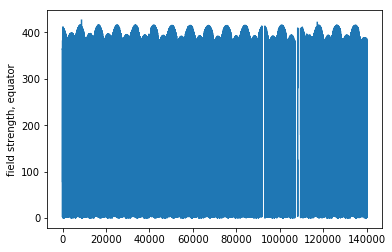

In [118]:
plt.figure()
plt.plot(data['b_equator'])
plt.ylabel('field strength, equator')
plt.show()